In [29]:

import pandas as pd
import seaborn as sns
import re, string
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
plt.style.use('ggplot')

[nltk_data] Error loading stopwords: <urlopen error [Errno 104]
[nltk_data]     Connection reset by peer>


In [30]:
train_data = pd.read_csv("/home/lzj/桌面/nlp/train.csv")
test_data = pd.read_csv("/home/lzj/桌面/nlp/test.csv")

In [31]:
#训练数据有7613个观察值和5个特征，包括目标(我们想要预测的标签)。
print("train_data shape:", train_data.shape) 
train_data.head()

train_data shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
#测试数据有3263个观察值和四个特征
print("test_data shape:",  test_data.shape)
test_data.head()

test_data shape: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
# 统计 trian_data 里面各类 twitter 数量

Real_len = train_data[train_data['target'] == 1].shape[0]
Not_len = train_data[train_data['target'] == 0].shape[0]
Real_len, Not_len

(3271, 4342)

In [34]:
# 先来看看 灾难 twitter 的样子
disaster_tweets = train_data[train_data['target']==1]['text']
disaster_tweets.values[1:5]

array(['Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

In [35]:
# 不是灾难的 twitter 的样子
non_disaster_tweets = train_data[train_data['target']==0]['text']
non_disaster_tweets.values[1:5]

array(['I love fruits', 'Summer is lovely', 'My car is so fast',
       'What a goooooooaaaaaal!!!!!!'], dtype=object)

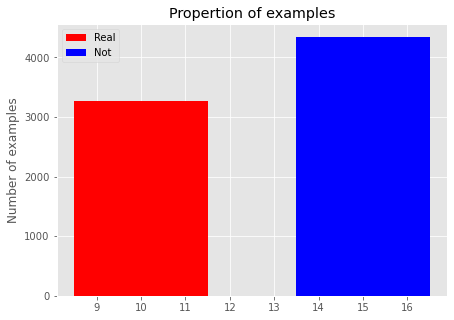

In [36]:
# 画出两类 twitter 数量统计直方图

plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='red')
plt.bar(15,Not_len,3, label="Not", color='blue')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

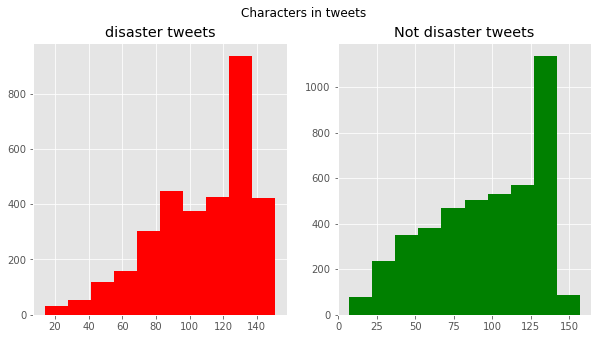

In [37]:
# 统计 字符数量与 最终目标的关系

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()
#从统计直方图可以看出， 无论是disaster 还是 No disaster tweets 大致字符范围是 120 ～ 140. 相差不大

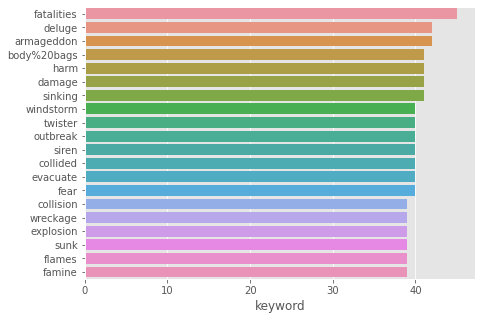

In [38]:
# 特征 “keyword” 分析
#让我们先来看看 前 20位 keyword 是什么样的

sns.barplot(y=train_data['keyword'].value_counts()[:20].index,x=train_data['keyword'].value_counts()[:20],
            orient='h')

In [39]:
#包含 词语"disaster" 的twitter 和 "target" 的关系

train_data.loc[train_data['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

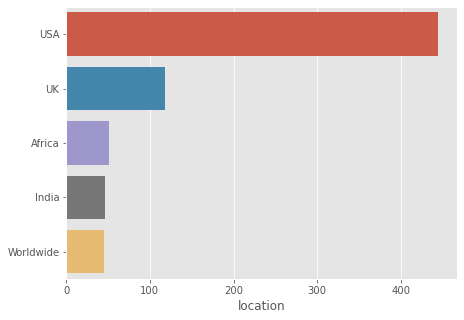

In [40]:
# 特征 “location” 分析
# 用简称 替换 标准名称， 并统计前 5 位
train_data['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train_data['location'].value_counts()[:5].index,x=train_data['location'].value_counts()[:5],
            orient='h')



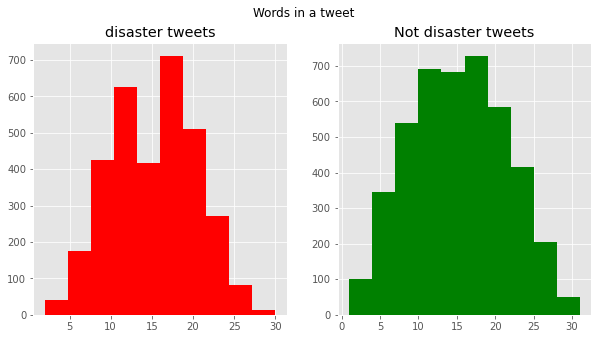

In [41]:
# 现在开始 "text" 特征分析， 这是最重要的特征

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

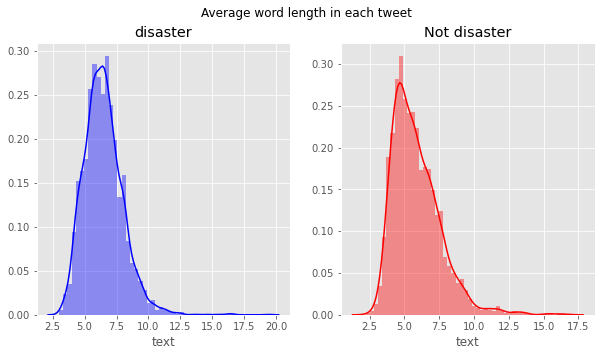

In [42]:
import numpy as np
# 统计平均 twitter 长度


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [43]:
# 在将数据传递给模型之前，需要对数据进行预处理， 比如转换数据到一个矩阵或向量；
# 一些基本的文本预处理技术包括，大小写，标点符号去除，转义字符等等；
# 现定义函数， 文本清理函数

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower() # 全部小写
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [44]:
# 同时对 train_data 和 test_data 的 "text" 类作清理
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))

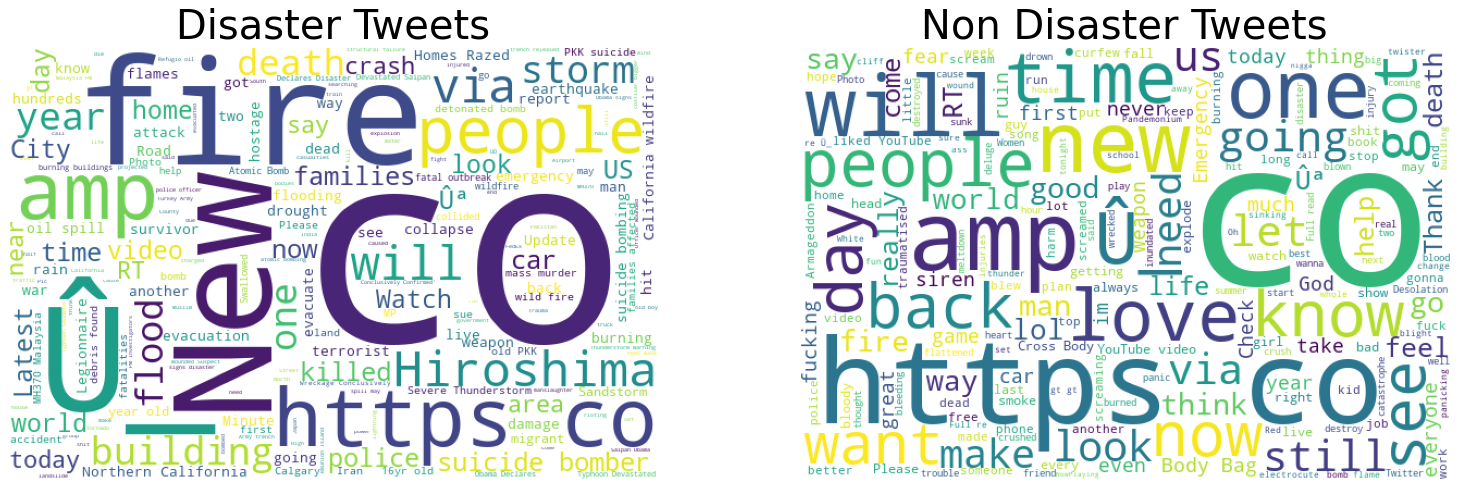

In [45]:
# 词云， just for fun
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [46]:
# 对文本分词
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_data['text'] = train_data['text'].apply(lambda x: tokenizer.tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x: tokenizer.tokenize(x))
train_data['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [47]:
# 移除 停词， 比如 the a an ...
from nltk.corpus import stopwords
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words
train_data['text'] = train_data['text'].apply(lambda x : remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [48]:
# 从新将 token List 转成文本 
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train_data['text'] = train_data['text'].apply(lambda x : combine_text(x))
test_data['text'] = test_data['text'].apply(lambda x : combine_text(x))
train_data['text']
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [49]:
# 合并
combine_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
combine_data

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officer...,1.0
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...,...
10871,10861,NaN,NaN,earthquake safety los angeles ûò safety fasten...,NaN
10872,10865,NaN,NaN,storm ri worse last hurricane hardest hit yard...,NaN
10873,10868,NaN,NaN,green line derailment chicago,NaN
10874,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN


In [50]:
# 文本 text 转换成向量， 这里使用 bag-of-words中 CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(combine_data["text"])# 这里是combine_data
train_vectors = count_vectorizer.transform(train_data["text"])
test_vectors = count_vectorizer.transform(test_data["text"])

print(train_vectors[0].todense())#打印第一个样本


[[0 0 0 ... 0 0 0]]


In [51]:
#TFIDF Features, 词频逆文档频率

from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf.fit_transform(combine_data["text"]) #这里依然是combine_data
train_tfidf = tfidf.transform(train_data["text"])
test_tfidf = tfidf.transform(test_data["text"])

print(train_tfidf[0].todense()) #打印第一个样本


[[0. 0. 0. ... 0. 0. 0.]]


In [52]:
# 开始引入模型
#Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

clf = LogisticRegression(C=1.0) #默认超参数
scores = model_selection.cross_val_score(clf, train_vectors, train_data["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [53]:
#使用 Gridsearchcv 搜索超参数
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LogisticRegression(), {"C": [1,2,3]}, cv=5)
clf.fit(train_vectors, train_data["target"])

print("best_pram:{0}, best_score:{1}".format(clf.best_params_, clf.best_score_))

best_pram:{'C': 1}, best_score:0.6888291919865608


In [54]:
#  Logistic Regression on TFIDF
from sklearn.model_selection import GridSearchCV

clf_tfidf = GridSearchCV(LogisticRegression(), {"C":[1,2,3,4,5]}, cv=5)
#scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train_data["target"], cv=5, scoring="f1")


clf_tfidf.fit(train_tfidf, train_data["target"])
print("best_pram:{0}, best_score:{1}".format(clf_tfidf.best_params_, clf_tfidf.best_score_))

best_pram:{'C': 1}, best_score:0.6923731862644014


In [55]:
#Naives Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train_data["target"], cv=5, scoring="f1")
scores #交叉验证

array([0.63157895, 0.60349854, 0.6845152 , 0.64521193, 0.72876712])

In [56]:
clf_NB.fit(train_vectors, train_data["target"])

MultinomialNB()

In [57]:
#  Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train_data["target"], cv=5, scoring="f1")
scores

#可以看出 朴素贝叶斯比逻辑斯蒂拟合效果要好.

array([0.57029703, 0.56787933, 0.60142349, 0.58933583, 0.72277228])

In [58]:
clf_NB_TFIDF.fit(train_tfidf, train_data["target"])

MultinomialNB()

In [59]:
#XGBoost

import xgboost as xgb
#clf_xgb = GridSearchCV(xgb.XGBClassifier(), {"max_depth":[2,4,6,8,10], "n_estimators":[150, 200, 250, 300]}, cv=5)
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train_data["target"], cv=5, scoring="f1")
scores


array([0.47240618, 0.36275461, 0.4432133 , 0.38900634, 0.53053435])

In [61]:
# Gridsearch 搜索 xgboost 超参数
clf_xgb = GridSearchCV(xgb.XGBClassifier(), {"max_depth":[2,4,6,8,10], "n_estimators":[150, 200, 250, 300]}, cv=5)
clf_xgb.fit(train_vectors, train_data["target"])
print("best_prame:{0}, best_score:{1}".format(clf_xgb.best_params_, clf.best_score_ ))

best_prame:{'max_depth': 10, 'n_estimators': 300}, best_score:0.6888291919865608


In [ ]:
#提交
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)


submission_file_path = "/home/lzj/桌面/nlp/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)    
    